In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import sys, os, csv, datetime
from typing import Dict
parent_directory = os.path.split(os.getcwd())[0]
src_directory = os.path.join(parent_directory, 'src')
data_directory = os.path.join('/scratch/groups/gracegao', 'Google_GNSS_data')
ephemeris_data_directory = os.path.join(data_directory, 'ephemeris')
sys.path.insert(0, src_directory)

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm.notebook import tqdm

import xarray as xr

/home/groups/gracegao/conda_envs/deep_gnss/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [4]:
from utils import *

from gnss_lib.sim_gnss import expected_measures, precompute_prange_satpos
import gnss_lib.sim_gnss as sgnss
from gnss_lib.utils import datetime_to_tow 
from gnss_lib import coordinates as coord

In [5]:
data_config = {
    "old_root": os.path.join(data_directory, "simulated_matlab_clockcorr_half_small"),
    "new_root": os.path.join(data_directory, "simulated_matlab_clockcorr_half_small_rebatched")
    }

In [6]:
initialize_dirs(data_config["new_root"])
dir_paths = setup_dir(data_config["new_root"], ["gnss_data", "processed"])

In [7]:
dir_paths

['/scratch/groups/gracegao/Google_GNSS_data/simulated_matlab_clockcorr_half_small_rebatched/gnss_data',
 '/scratch/groups/gracegao/Google_GNSS_data/simulated_matlab_clockcorr_half_small_rebatched/processed']

In [39]:
debug_res_list = []
def debug_residuals(data, satXYZV, true_XYZb, prange_corr):
    delXYZ, true_range = sgnss._find_delxyz_range(satXYZV, true_XYZb[:3], len(satXYZV.index))
    return true_range + prange_corr + true_XYZb[3] - data['prange'].to_numpy()

traj_data = np.zeros((len(list1), 100, 4))

In [40]:
list1 = sorted_list(data_config["old_root"])
for j in tqdm(range(len(list1)), desc='files'):
    filepath = list1[j]
    fulldata = pd.read_csv(filepath)
    outname = filepath.split('/')[-1][:-4]
    list2 = fulldata['t_idx'].unique()
    for i in range(len(list2)):
        timestep = list2[i]
        data = fulldata[fulldata['t_idx']==timestep]

        # Calculate corrections
        gpsweek, tow = datetime_to_tow(pd.to_datetime(timestep))
        ephem = data.set_index('sv')
        _data0 = data.iloc[0]

        # Change to WLS or some other approximate initialization
        true_XYZb = np.array([_data0['Rxx'], _data0['Rxy'], _data0['Rxz'], _data0['b'], _data0['Rxvx'], _data0['Rxvy'], _data0['Rxvz'], _data0['b_dot']])

        # Generate expected measures and satellite positions/velocities
        prange_corr, satXYZV = precompute_prange_satpos(gpsweek, tow, ephem, true_XYZb[:3], true_XYZb[3], true_XYZb[7], true_XYZb[4:7])

        tmp_res = debug_residuals(data, satXYZV, true_XYZb, prange_corr)
        debug_res_list.append(tmp_res)
        
        traj_data[j, i, :] = true_XYZb[:4]
        sim_data = {
            "timestamp": data['t_idx'].to_numpy(), 
            "gt_x": data['Rxx'].to_numpy(),
            "gt_y": data['Rxy'].to_numpy(),
            "gt_z": data['Rxz'].to_numpy(),
            "gt_b": data['b'].to_numpy(),
            "gt_vx": data['Rxvx'].to_numpy(),
            "gt_vy": data['Rxvy'].to_numpy(),
            "gt_vz": data['Rxvz'].to_numpy(),
            "gt_vb": data['b_dot'].to_numpy(),
            "prange": data['prange'].to_numpy(), 
            "prange_corr": prange_corr, 
            "doppler": data['doppler'].to_numpy(), 
            "sv_x": satXYZV['x'].to_numpy(),
            "sv_y": satXYZV['y'].to_numpy(),
            "sv_z": satXYZV['z'].to_numpy(),
            "sv_vx": satXYZV['vx'].to_numpy(),
            "sv_vy": satXYZV['vy'].to_numpy(),
            "sv_vz": satXYZV['vz'].to_numpy(),
                   }

        new_data = pd.DataFrame(data=sim_data)
        
        new_data.to_hdf(os.path.join(dir_paths[0], outname+'_'+str(i)+'.h5'), key='new_data')

files: 100%|██████████| 18/18 [04:38<00:00, 15.47s/it]


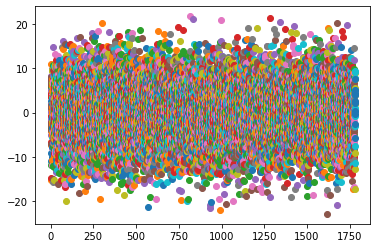

In [41]:
# # PLOT RESIDUALS
# for i, res_l in enumerate(debug_res_list):
#     plt.scatter([i]*len(res_l), res_l)

# # PLOT TRAJECTORY
# i = 1

# plt.figure()
# plt.plot(traj_data[i, :, 0])

# plt.figure()
# plt.plot(traj_data[i, :, 1])

# plt.figure()
# plt.plot(traj_data[i, :, 2])

# plt.figure()
# plt.plot(traj_data[i, :, 3])

In [105]:
tmp = pd.read_hdf(os.path.join(dir_paths[0], outname+'_'+str(i)+'.h5'), 'new_data')

In [106]:
tmp

,timestamp,gt_x,gt_y,gt_z,gt_b,gt_vx,gt_vy,gt_vz,gt_vb,prange,prange_corr,doppler,sv_x,sv_y,sv_z,sv_vx,sv_vy,sv_vz
0,2020-05-15 00:47:45.348796+00:00,-2.699656e+06,-2.699656e+06,-2.700623e+06,-8.519005,-0.176964,-0.218599,0.391817,-0.017047,2.229790e+07,-102278.676266,669.031694,-1.918665e+07,-5.064791e+06,-1.767907e+07,-1243.299195,-1883.856974,1856.541112
1,2020-05-15 00:47:45.348796+00:00,-2.699656e+06,-2.699656e+06,-2.700623e+06,-8.519005,-0.176964,-0.218599,0.391817,-0.017047,2.272663e+07,35330.285894,882.322114,-9.222675e+06,-2.383271e+07,-7.774067e+06,679.735860,690.254858,-2998.904208
2,2020-05-15 00:47:45.348796+00:00,-2.699656e+06,-2.699656e+06,-2.700623e+06,-8.519005,-0.176964,-0.218599,0.391817,-0.017047,2.512502e+07,-3886.523486,2192.190963,-1.769064e+07,1.491627e+07,-1.251956e+07,540.851691,-1582.500103,-2596.798789
3,2020-05-15 00:47:45.348796+00:00,-2.699656e+06,-2.699656e+06,-2.700623e+06,-8.519005,-0.176964,-0.218599,0.391817,-0.017047,2.351584e+07,-69297.300262,-1435.297171,2.052759e+06,-2.534114e+07,-7.287228e+06,633.949498,-746.329469,2936.060391
4,2020-05-15 00:47:45.348796+00:00,-2.699656e+06,-2.699656e+06,-2.700623e+06,-8.519005,-0.176964,-0.218599,0.391817,-0.017047,2.539910e+07,56902.608869,-2117.144483,-2.194574e+07,-7.066604e+06,1.319734e+07,1646.885220,-377.464375,2532.926610
5,2020-05-15 00:47:45.348796+00:00,-2.699656e+06,-2.699656e+06,-2.700623e+06,-8.519005,-0.176964,-0.218599,0.391817,-0.017047,2.255546e+07,158198.966064,-891.748471,-2.163483e+07,-1.335320e+07,-8.141103e+06,-488.992682,-952.208338,2867.224908
6,2020-05-15 00:47:45.348796+00:00,-2.699656e+06,-2.699656e+06,-2.700623e+06,-8.519005,-0.176964,-0.218599,0.391817,-0.017047,2.564680e+07,-421.527463,-2404.025421,-2.313604e+07,-4.742482e+06,1.266041e+07,1426.223038,-524.748492,2592.194068
7,2020-05-15 00:47:45.348796+00:00,-2.699656e+06,-2.699656e+06,-2.700623e+06,-8.519005,-0.176964,-0.218599,0.391817,-0.017047,2.266322e+07,-3905.196225,-1072.362842,-4.462884e+06,-1.524582e+07,-2.149647e+07,2646.076237,-491.971323,-165.733619
8,2020-05-15 00:47:45.348796+00:00,-2.699656e+06,-2.699656e+06,-2.700623e+06,-8.519005,-0.176964,-0.218599,0.391817,-0.017047,2.320122e+07,1227.529425,1875.246301,-1.664306e+07,-2.083958e+07,1.141808e+06,91.932758,-285.045836,-3164.487834
9,2020-05-15 00:47:45.348796+00:00,-2.699656e+06,-2.699656e+06,-2.700623e+06,-8.519005,-0.176964,-0.218599,0.391817,-0.017047,2.393858e+07,84114.185411,1831.281427,-1.730299e+07,7.520190e+06,-1.855412e+07,765.151907,-2258.916433,-1636.294511


array([ 15.19841867,  29.78512039,  34.52667313, -15.08367835,
       -38.25255371, -10.50373182, -43.61638873, -20.5923256 ,
        30.36762711,  51.22942183])